In [15]:
import os
import pandas as pd
import numpy as np
from numpy import var, mean, sqrt
import pyfaidx
import pysam
from adjustText import adjust_text
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, ttest_ind
from statannotations.Annotator import Annotator
from statsmodels.stats.multitest import multipletests

In [16]:
MUT_DATA = "../data/annotated_snv_mv_indels_by_cancer_subtype"
DRIVER_GENES = "../data/driver_genes"
TFBS_DATA = "../data/TFBS_data_diff"
REF_FASTA = "../data/ref/hg19.fa"
DRIVER_GENES_PANCAN = "../data/datasets/driver_genes_intogen/Pancancer.tsv"
CANCER_GENE_TYPES = "../metadata/cancer_genes.tsv"

RESULTS_DIR = "../results/TFBS_diff"
os.makedirs(RESULTS_DIR, exist_ok=True)
PLOTS_DIR = "../results/PCAWG"
os.makedirs(PLOTS_DIR, exist_ok=True)
PLOT_DATA_DIR = "../plot_data/TFBS_Fabian"
os.makedirs(PLOT_DATA_DIR, exist_ok=True)

# Fasta sequence extractor
pyfaidx.Faidx(REF_FASTA)
REF_GENOME_OPEN = pysam.Fastafile(REF_FASTA) 

CANCER_TYPES = os.listdir(DRIVER_GENES) # all cancer types
CANCER_TYPES = [cancer_type for cancer_type in CANCER_TYPES if cancer_type.endswith(".tsv")]
CANCER_TYPES = [cancer_type.replace(".tsv", "") for cancer_type in CANCER_TYPES]
CANCER_TYPES.remove("Pancancer")
print(len(CANCER_TYPES), CANCER_TYPES)

31 ['CNS-Oligo', 'Kidney-ChRCC', 'Prost-AdenoCA', 'Kidney-RCC', 'Stomach-AdenoCA', 'CNS-Medullo', 'Thy-AdenoCA', 'Myeloid-MPN', 'Bone-Leiomyo', 'Lymph-BNHL', 'Myeloid-AML', 'Lung-AdenoCA', 'CNS-GBM', 'Head-SCC', 'Breast-AdenoCa', 'Ovary-AdenoCA', 'CNS-PiloAstro', 'Cervix-SCC', 'Liver-HCC', 'Bone-Osteosarc', 'Biliary-AdenoCA', 'Skin-Melanoma', 'Lung-SCC', 'Lymph-CLL', 'Panc-Endocrine', 'Bladder-TCC', 'Panc-AdenoCA', 'ColoRect-AdenoCA', 'Breast-LobularCa', 'Eso-AdenoCa', 'Uterus-AdenoCA']


In [17]:
pancan_driver_genes = pd.read_csv(DRIVER_GENES_PANCAN, sep="\t")
pancan_driver_genes = pancan_driver_genes[["Symbol", "Samples (%)"]]
pancan_driver_genes = pancan_driver_genes[pancan_driver_genes["Samples (%)"] >= 1]
print(pancan_driver_genes.shape)
driver_genes_list = pancan_driver_genes["Symbol"].tolist()

(31, 2)


In [18]:
mut_df = pd.DataFrame()
for cancer_type in CANCER_TYPES:	
	mut_cancer_df = pd.read_csv(f"{MUT_DATA}/{cancer_type}.tsv", sep="\t")
	mut_cancer_df = mut_cancer_df[["Tumor_Sample_Barcode", "mutation", "gene", "driver", "has_driver", "genic_region"]]
	mut_cancer_df["cancer_type"] = cancer_type

	driver_genes = pd.read_csv(f"{DRIVER_GENES}/{cancer_type}.tsv", sep="\t")
	driver_genes_list = driver_genes["gene"].tolist()
	mut_cancer_df = mut_cancer_df[mut_cancer_df["gene"].isin(driver_genes_list)]
	mut_df = pd.concat([mut_df, mut_cancer_df], axis=0)

# get driver status
mut_df["driver_status"] = mut_df.apply(lambda x: "Passengers in presence of driver" if x["has_driver"] else "Passengers in absence of driver", axis=1)
mut_df["driver_status"] = mut_df.apply(lambda x: "Drivers" if x["driver"] else x["driver_status"], axis=1)

/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_99850/2658361822.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  mut_cancer_df = pd.read_csv(f"{MUT_DATA}/{cancer_type}.tsv", sep="\t")
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_99850/2658361822.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  mut_cancer_df = pd.read_csv(f"{MUT_DATA}/{cancer_type}.tsv", sep="\t")
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_99850/2658361822.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  mut_cancer_df = pd.read_csv(f"{MUT_DATA}/{cancer_type}.tsv", sep="\t")
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_99850/2658361822.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  mut_cancer_df = pd.read_csv(f"{MUT_DATA}/{cancer_ty

In [19]:
def get_key(mutation):
	'''
	Generate a key to match the mutation format for TFBS data
	Used to merge the two dataframes on the mutation
	'''
	chrom, pos, ref, alt = mutation.split(":")
	pos = pos.split("-")[0]
	# using 0-based indexing for pysam fetch
	start = int(pos)-1
	end = int(pos)
	# include the previous base in case of indels and MNVs
	if ref == "-":
		ref = REF_GENOME_OPEN.fetch(f"chr{chrom}", start-1, start)
		alt = REF_GENOME_OPEN.fetch(f"chr{chrom}", start-1, end)
		pos = int(pos) - 1
	elif alt == "-":
		ref = REF_GENOME_OPEN.fetch(f"chr{chrom}", start-1, end)
		alt = REF_GENOME_OPEN.fetch(f"chr{chrom}", start-1, start)
		pos = int(pos) - 1
	elif len(ref) > 1 or len(alt) > 1:
		ref = REF_GENOME_OPEN.fetch(f"chr{chrom}", start-1, end)
		alt = REF_GENOME_OPEN.fetch(f"chr{chrom}", start-1, start) + alt
		pos = int(pos) - 1
	key = f"chr{chrom}:{pos}{ref}>{alt}"
	return key

# add variant column to use as key for TFBS data
mut_df["variant"] = mut_df["mutation"].apply(get_key)

In [20]:
# TFBS data
tfbs_data_file = f"{TFBS_DATA}/all_variants.tsv"
if os.path.exists(tfbs_data_file):
	tfbs_df = pd.read_csv(tfbs_data_file, sep="\t")
else:
	tfbs_df = pd.DataFrame()
	for cancer_type in CANCER_TYPES:
		tf_cancer_file = f"{TFBS_DATA}/{cancer_type}.tsv"
		if not os.path.exists(tf_cancer_file):
			print(f"TFBS data file not found for {cancer_type}")
			continue
		tfbs_cancer_df = pd.read_csv(f"{TFBS_DATA}/{cancer_type}.tsv", sep="\t")
		tfbs_cancer_df = tfbs_cancer_df[["variant", "tf", "score"]]
		tfbs_df = pd.concat([tfbs_df, tfbs_cancer_df], axis=0)
	# remove duplicates
	tfbs_df = tfbs_df.drop_duplicates(subset=["variant", "tf"])
	tfbs_df["variant_tf"] = tfbs_df["variant"] + "_" + tfbs_df["tf"]
	tfbs_df.to_csv(tfbs_data_file, sep="\t", index=False)
tfbs_var_dict = tfbs_df.set_index("variant_tf")["score"].to_dict()

In [21]:
mut_tf_df = mut_df[["Tumor_Sample_Barcode", "variant", "gene", "driver_status", "genic_region", "cancer_type"]].copy()
mut_tf_df = mut_tf_df[mut_tf_df["genic_region"] == "upstream"]
print(mut_tf_df.shape)
mut_tf_df.drop_duplicates(inplace=True)
print(mut_tf_df.shape)

(423, 6)
(423, 6)


In [22]:
def cohen_d(x, y):
    # size of samples
    n1, n2 = len(x), len(y)
    # variance of the samples
    s1, s2 = var(x, ddof=1), var(y, ddof=1)
    # pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # means of the samples
    u1, u2 = mean(x), mean(y)
    # return the effect size
    return (u1 - u2) / s

In [23]:
tf_diff = []
tfs = tfbs_df["tf"].unique().tolist()
mut_tf_data = pd.DataFrame()
for tf in tfs:
	mut_data_df = mut_tf_df.copy()
	mut_data_df["tf"] = tf
	mut_data_df["score"] = mut_data_df.apply(lambda x: tfbs_var_dict.get(f"{x['variant']}_{tf}", 0), axis=1).astype(float)
	mut_data_df["abs_score"] = mut_data_df["score"].abs()
	mut_data_df["prediction"] = mut_data_df["score"].apply(lambda x: "gain" if x > 0 else "loss")
	mut_data_df["prediction"] = mut_data_df["prediction"].apply(lambda x: "no change" if x == 0 else x)
	mut_tf_data = pd.concat([mut_tf_data, mut_data_df], axis=0)
mut_tf_data.reset_index(drop=True, inplace=True)
print(mut_tf_data.shape)

(586701, 10)


In [24]:
def get_cancer_gene_type(is_oncogene, is_tsg):
    if is_oncogene == "Yes" and is_tsg == "No":
        return "OG"
    elif is_oncogene == "No" and is_tsg == "Yes":
        return "TSG"
    elif is_oncogene == "Yes" and is_tsg == "Yes":
        return "Both"
    else:
        return "Neither"

cancer_gene_type = pd.read_csv(CANCER_GENE_TYPES, sep="\t")
cancer_gene_type["type"] = cancer_gene_type.apply(lambda x: get_cancer_gene_type(x["Is Oncogene"], x["Is Tumor Suppressor Gene"]), axis=1)
cancer_gene_type = cancer_gene_type[["Hugo Symbol", "type"]]
cancer_gene_type.columns = ["gene", "type"]
mut_tf_data = mut_tf_data.merge(cancer_gene_type, on="gene", how="left")
mut_tf_data["type"] = mut_tf_data["type"].fillna("Neither")

In [25]:
# gene = "FBXW7"
# plot_data = mut_tf_data[mut_tf_data["gene"] == gene]
plot_data = mut_tf_data[mut_tf_data["driver_status"] != "Drivers"]
plot_data["driver_mutation_status"] = plot_data["driver_status"].apply(lambda x: True if x == "Passengers in presence of driver" else False)
print(plot_data.shape)

(406391, 12)


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_99850/703100509.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data["driver_mutation_status"] = plot_data["driver_status"].apply(lambda x: True if x == "Passengers in presence of driver" else False)


In [26]:
# Group by TF and condition to get list of scores
grouped = plot_data.groupby(['tf', 'driver_status'])['abs_score'].apply(list).unstack()

# Compute statistics
results = []
for tf in grouped.index:
    group1 = grouped.loc[tf, 'Passengers in absence of driver']
    group2 = grouped.loc[tf, 'Passengers in presence of driver']
    stat, pval = ttest_ind(group1, group2, equal_var=False)
    diff = np.mean(group1) - np.mean(group2)
    results.append({'tf': tf, 'p_val': pval, 'diff': diff})
    
volcano_df = pd.DataFrame(results)
volcano_df.dropna(inplace=True) 
volcano_df["log_p"] = volcano_df["p_val"].apply(lambda x: -np.log10(x))
# multiple testing correction
rejected, pvals_corrected, _, _ = multipletests(volcano_df['p_val'], method='fdr_bh')
volcano_df['pval_adj'] = pvals_corrected
volcano_df["log_p_adj"] = volcano_df["pval_adj"].apply(lambda x: -np.log10(x))
volcano_df["direction"] = volcano_df["diff"].apply(lambda x: "Larger effects in\nabsence of driver" if x > 0 else "Larger effects in\npresence of driver")

# count number of TFs with significant p-values
num_significant = len(volcano_df[volcano_df["pval_adj"] < 0.05])
print(f"Number of TFs with significant p-values: {num_significant}")
num_non_significant = len(volcano_df[volcano_df["pval_adj"] >= 0.05])
print(f"Number of TFs without significant p-values: {num_non_significant}")

Number of TFs with significant p-values: 107
Number of TFs without significant p-values: 1280


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_99850/1248053525.py:6: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(


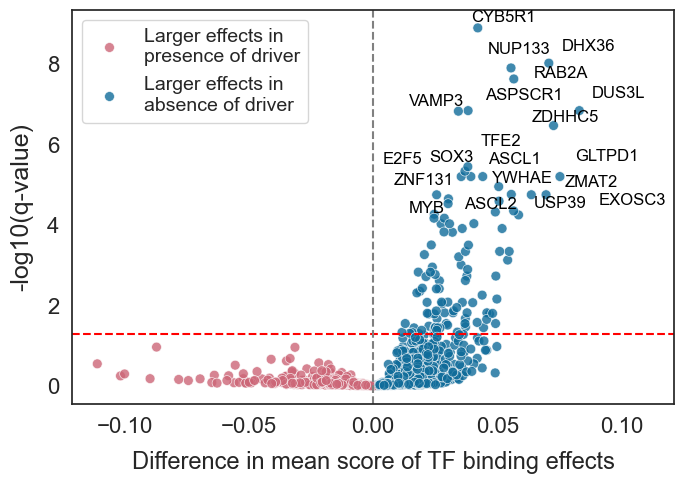

In [27]:
plt.figure(figsize=(7, 5))
sns.set(style="white")
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)

sns.scatterplot(
    data=volcano_df, 
    x='diff', 
    y='log_p_adj',
	hue='direction',
	palette=cmap,
	s=50,
	edgecolor='w',
	linewidth=0.5,
	alpha=0.8
)
plt.axhline(-np.log10(0.05), color='red', linestyle='--')  # p = 0.05 cutoff
plt.axvline(0, color='gray', linestyle='--')  # no difference cutoff

# center x axis at 0
max_abs = max(abs(volcano_df["diff"].min()), abs(volcano_df["diff"].max()))
max_abs += 0.01
plt.xlim(-max_abs, max_abs)

# avoid overlapping text
annot = []
top_tfs = volcano_df.nlargest(20, 'log_p_adj')["tf"].tolist() # get top TFs by significance
for index, row in volcano_df.iterrows():
	if row["log_p_adj"] > -np.log10(0.05) and row["diff"] > 0 and row["tf"] in top_tfs:
		annot.append(plt.text(row["diff"], row["log_p_adj"], row["tf"], fontsize=12, ha='center', va='bottom', color='black'))
	elif row["log_p_adj"] > -np.log10(0.05) and row["diff"] < 0 and row["tf"] in top_tfs:
		annot.append(plt.text(row["diff"], row["log_p_adj"], row["tf"], fontsize=12, ha='center', va='bottom', color='red'))
adjust_text(annot)

plt.xticks(fontsize=16)
plt.xlabel('Difference in mean score of TF binding effects', fontsize=17, labelpad=10)
plt.yticks(fontsize=16)
plt.ylabel('-log10(q-value)', fontsize=18, labelpad=10)
plt.legend(title_fontsize=14, loc='upper left', fontsize=14)
plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/pancancer_tfbs_diff.png", bbox_inches='tight', dpi=300)

# source data
volcano_df[["tf", "diff", "p_val", "pval_adj"]].to_csv(f"{PLOT_DATA_DIR}/TFBS_effects_passenger_mutations.tsv", sep="\t", index=False)

(49932, 12)
(1387, 2)
Number of TFs with significant p-values: 0
Number of TFs without significant p-values: 1387
(287109, 12)


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_99850/3907894722.py:37: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(


(1387, 2)
Number of TFs with significant p-values: 209
Number of TFs without significant p-values: 1178


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_99850/3907894722.py:37: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(


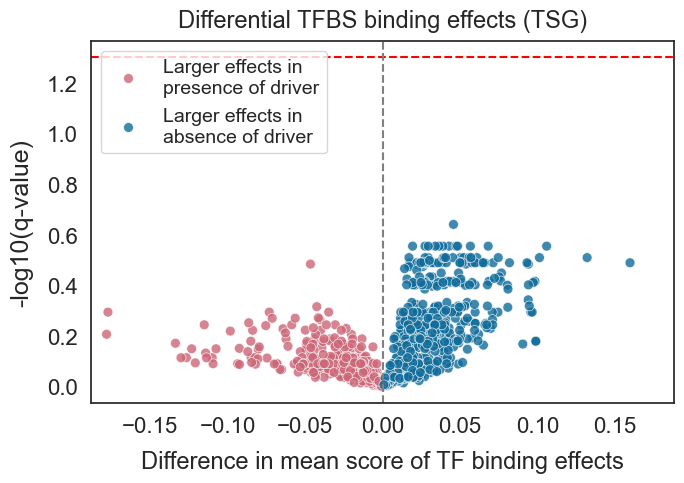

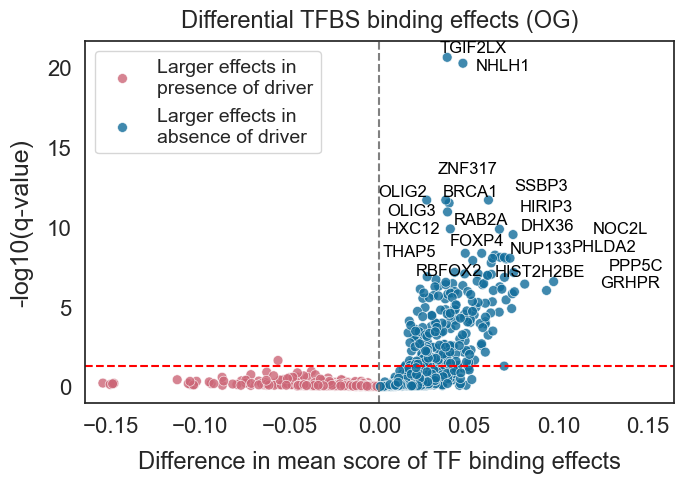

In [28]:
for gene_type in ["TSG", "OG"]:
    # Group by TF and condition to get list of scores
    selected_plot_data = plot_data[plot_data["type"] == gene_type]
    print(selected_plot_data.shape)
    grouped = selected_plot_data.groupby(['tf', 'driver_status'])['abs_score'].apply(list).unstack()
    print(grouped.shape)

    # Compute statistics
    results = []
    for tf in grouped.index:
        group1 = grouped.loc[tf, 'Passengers in absence of driver']
        group2 = grouped.loc[tf, 'Passengers in presence of driver']
        stat, pval = ttest_ind(group1, group2, equal_var=False)
        diff = np.mean(group1) - np.mean(group2)
        results.append({'tf': tf, 'p_val': pval, 'diff': diff})
    
    volcano_df = pd.DataFrame(results)
    volcano_df.dropna(inplace=True) 
    volcano_df["log_p"] = volcano_df["p_val"].apply(lambda x: -np.log10(x))
    # multiple testing correction
    rejected, pvals_corrected, _, _ = multipletests(volcano_df['p_val'], method='fdr_bh')
    volcano_df['pval_adj'] = pvals_corrected
    volcano_df["log_p_adj"] = volcano_df["pval_adj"].apply(lambda x: -np.log10(x))
    volcano_df["direction"] = volcano_df["diff"].apply(lambda x: "Larger effects in\nabsence of driver" if x > 0 else "Larger effects in\npresence of driver")

    # count number of TFs with significant p-values
    num_significant = len(volcano_df[volcano_df["pval_adj"] < 0.05])
    print(f"Number of TFs with significant p-values: {num_significant}")
    num_non_significant = len(volcano_df[volcano_df["pval_adj"] >= 0.05])
    print(f"Number of TFs without significant p-values: {num_non_significant}")

    plt.figure(figsize=(7, 5))
    sns.set(style="white")
    colors = ["#CC6677", "#106C9A", "#529267"]
    cmap = sns.color_palette(colors)

    sns.scatterplot(
        data=volcano_df, 
        x='diff', 
        y='log_p_adj',
        hue='direction',
        palette=cmap,
        s=50,
        edgecolor='w',
        linewidth=0.5,
        alpha=0.8
    )
    plt.axhline(-np.log10(0.05), color='red', linestyle='--')  # p = 0.05 cutoff
    plt.axvline(0, color='gray', linestyle='--')  # no difference cutoff

    # center x axis at 0
    max_abs = max(abs(volcano_df["diff"].min()), abs(volcano_df["diff"].max()))
    max_abs += 0.01
    plt.xlim(-max_abs, max_abs)

    # avoid overlapping text
    annot = []
    top_tfs = volcano_df.nlargest(20, 'log_p_adj')["tf"].tolist() # get top TFs by significance
    for index, row in volcano_df.iterrows():
        if row["log_p_adj"] > -np.log10(0.05) and row["diff"] > 0 and row["tf"] in top_tfs:
            annot.append(plt.text(row["diff"], row["log_p_adj"], row["tf"], fontsize=12, ha='center', va='bottom', color='black'))
        elif row["log_p_adj"] > -np.log10(0.05) and row["diff"] < 0 and row["tf"] in top_tfs:
            annot.append(plt.text(row["diff"], row["log_p_adj"], row["tf"], fontsize=12, ha='center', va='bottom', color='red'))
    adjust_text(annot)

    plt.xticks(fontsize=16)
    plt.xlabel('Difference in mean score of TF binding effects', fontsize=17, labelpad=10)
    plt.yticks(fontsize=16)
    plt.ylabel('-log10(q-value)', fontsize=18, labelpad=10)
    plt.title(f'Differential TFBS binding effects ({gene_type})', fontsize=17, pad=10)
    plt.legend(title_fontsize=14, loc='upper left', fontsize=14)
    plt.tight_layout()
    plt.savefig(f"{PLOTS_DIR}/pancancer_tfbs_diff_{gene_type}.png", dpi=300)

    # source data
    volcano_df[["tf", "diff", "p_val", "pval_adj"]].to_csv(f"{PLOT_DATA_DIR}/TFBS_effects_passenger_mutations_{gene_type}.tsv", sep="\t", index=False)